In [ ]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import cm
from scipy.ndimage import laplace
from matplotlib import animation
import time
from functools import partial
from scipy.integrate import solve_ivp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sympy import symbols, diff
from matplotlib.patches import Rectangle
from sympy import symbols, diff
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.optimize import root
from matplotlib.colors import ListedColormap, Normalize

from sympy import symbols, diff
from joblib import Parallel, delayed

def solve_ss2(k1, k2, params,given_sol):
    # Define symbolic variables
    m, p = sp.symbols('m p', real=True)
    b_m, v_m, k_m, mu_m, mu_p = sp.symbols('b_m v_m k_m mu_m mu_p', real=True)
    kon, koff = sp.symbols('kon, koff', real=True)

    # Define steady-state equations
    r_d_m = b_m + v_m/(1+(k_m/m)**2) - mu_m*m - kon*(m**2) + koff*P
    r_d_p = kon* + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b

    # Assign values to variables
    mod_pars = params[2:]
    values = {
        b_a: mod_pars[3],
        v_a: mod_pars[0],
        k_ba: mod_pars[2],
        mu_a: mod_pars[5],
        b_b: mod_pars[4],
        v_b: mod_pars[1],
        mu_b: mod_pars[6],
        k_a: k1,
        k_ab: k2,
    }

    # Convert symbolic expressions into numerical functions
    r_d_a_num = r_d_a.subs(values)
    r_d_b_num = r_d_b.subs(values)

    # Define system of equations
    def equations(vars):
        a_val, b_val = vars
        return np.array([r_d_a_func(a_val, b_val), r_d_b_func(a_val, b_val)])

    # steady_state = given_sol
    # u0 = sp.nsolve([r_d_a_num, r_d_b_num], [a, b], steady_state, prec = 100)
    # return u0

    # Try multiple initial guesses
    initial_guesses =  [0.1, 0.1], [1, 1], [4, 2], [10, 5]

    for guess in initial_guesses:
        try:
            sol = sp.nsolve([r_d_a_num, r_d_b_num], [a, b], guess, prec=20)
            return sol
        except Exception:
            continue

    raise RuntimeError("No solution found with any initial guess in solve_ss2")

    

params = [
    1,       # D_A: activator diffusion
    25,      # D_B: inhibitor diffusion (moderately faster than D_A)
    3500,     # V_A: 
    3500,    # V_B: 
    0.5,     # k_BA: 
    1,    # b_A: 
    1,    # b_B: 
    6,     # μ_A: 
    8       # μ_B: 
] 

In [4]:

data = np.load('turing_region2.npz')
X = data['X']
Y = data['Y']
Turing_region = data['Turing_region']

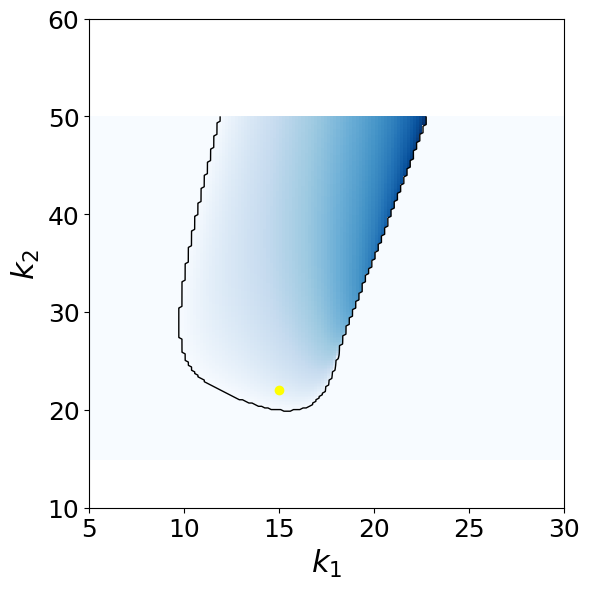

In [20]:
cmap = plt.cm.Blues.copy()

norm = Normalize(vmin=0, vmax=np.max(Turing_region))
# ✅ Add collection to axes, not plt
plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, Turing_region, shading="auto", cmap=cmap,norm = norm)
plt.contour(
    X, Y, Turing_region,
    levels=[0],          
    colors="black",
    linewidths=1,
    zorder=5             
)
k1val, k2val = 15,22
plt.scatter(k1val, k2val, color ='yellow')

plt.xlim(5,30)
plt.ylim(10,60)
plt.xlabel(r"$k_1$",fontsize = 22)
plt.ylabel(r"$k_2$",fontsize = 22)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.tight_layout()
#plt.savefig("Images_for_paper/supp_fig8a")
plt.show()


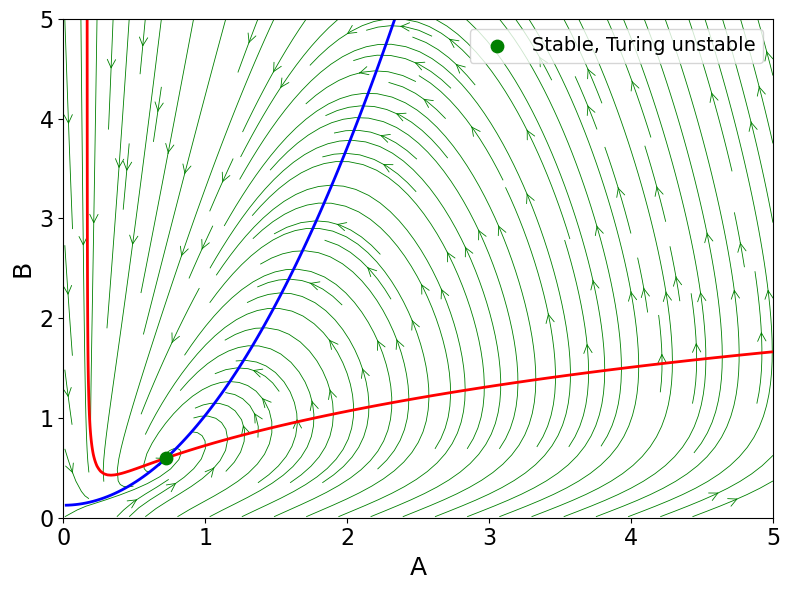

In [21]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
params = [
    1,       # D_A: activator diffusion
    25,      # D_B: inhibitor diffusion
    3500,    # V_A
    3500,    # V_B
    0.5,     # k_BA
    1,       # b_A
    1,       # b_B
    6,       # μ_A
    8        # μ_B
]
k1, k2 = k1val, k2val
D_u, D_v = params[0], params[1]

# Define variables
a, b = sp.symbols('a b', real=True)
b_a, v_a, k_a, k_ba, mu_a = sp.symbols('b_a v_a k_a k_ba mu_a', real=True)
b_b, v_b, k_ab, mu_b = sp.symbols('b_b v_b k_ab mu_b', real=True)

# System
r_d_a = b_a + v_a * 1/(1+(k_a/a)**2) * 1/(1+(b/k_ba)**2) - mu_a*a
r_d_b = b_b + v_b * 1/(1+(k_ab/a)**2) - mu_b*b

# Parameters
mod_pars = params[2:]
values = {
    b_a: mod_pars[3],
    v_a: mod_pars[0],
    k_ba: mod_pars[2],
    mu_a: mod_pars[5],
    b_b: mod_pars[4],
    v_b: mod_pars[1],
    mu_b: mod_pars[6],
    k_a: k1,
    k_ab: k2,
}

# Jacobian
J = sp.Matrix([
    [sp.diff(r_d_a, a), sp.diff(r_d_a, b)],
    [sp.diff(r_d_b, a), sp.diff(r_d_b, b)]
]).subs(values)

# Functions
f_a = sp.lambdify((a, b), r_d_a.subs(values), "numpy")
f_b = sp.lambdify((a, b), r_d_b.subs(values), "numpy")

# Solve steady states
steady_states = []
for guess in [(0.5,0.5), (1,1), (2,1), (3,2), (5,2)]:
    try:
        sol = sp.nsolve([r_d_a.subs(values), r_d_b.subs(values)], [a, b], guess, tol=1e-14, maxsteps=100)
        sol = (float(sol[0]), float(sol[1]))
        if not any(np.allclose(sol, ss, atol=1e-3) for ss in steady_states):
            steady_states.append(sol)
    except Exception:
        continue

# Classify steady states
stable_points = []
unstable_points = []
turing_points = []

for ss in steady_states:
    # ODE Jacobian
    J_num = np.array(J.subs({a: ss[0], b: ss[1]}).evalf(), dtype=float)
    eigvals = np.linalg.eigvals(J_num)

    if np.all(np.real(eigvals) < 0):  # Stable ODE
        # Test dispersion relation
        ks = np.linspace(0.01, 5, 200)
        turing_instability = False
        for k in ks:
            M = J_num - np.diag([D_u*k**2, D_v*k**2])
            lam = np.linalg.eigvals(M)
            if np.max(np.real(lam)) > 0:
                turing_instability = True
                break
        if turing_instability:
            turing_points.append(ss)
        else:
            stable_points.append(ss)
    else:
        unstable_points.append(ss)

# Grid for phase plane
a_vals = np.linspace(0.01, 5, 200)
b_vals = np.linspace(0.01, 5, 200)
A, B = np.meshgrid(a_vals, b_vals)
FA = f_a(A, B)
FB = f_b(A, B)

# Plot
plt.figure(figsize=(8, 6))
plt.streamplot(A, B, FA, FB, density=1.5, color="green", arrowsize=1.5,arrowstyle='->', linewidth = 0.6)
plt.contour(A, B, FA, levels=[0], colors="red", linewidths=2)
plt.contour(A, B, FB, levels=[0], colors="blue", linewidths=2)

# Steady states
if stable_points:
    stable_points = np.array(stable_points)
    plt.scatter(stable_points[:,0], stable_points[:,1], color="black", s=60, label="Stable", zorder = 5)
if turing_points:
    turing_points = np.array(turing_points)
    plt.scatter(turing_points[:,0], turing_points[:,1], color="green", s=80, label="Stable, Turing unstable",zorder = 5)
if unstable_points:
    unstable_points = np.array(unstable_points)
    plt.scatter(unstable_points[:,0], unstable_points[:,1], facecolors='none', edgecolors='black', s=80, label="Unstable",zorder = 5)

plt.xlabel("A",fontsize = 18)
plt.ylabel("B",fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(0,5)
plt.ylim(0,5)
plt.legend(loc = 'upper right',fontsize = 14)
plt.tight_layout()
plt.savefig("Images_for_paper/supp_fig8b")
plt.show()

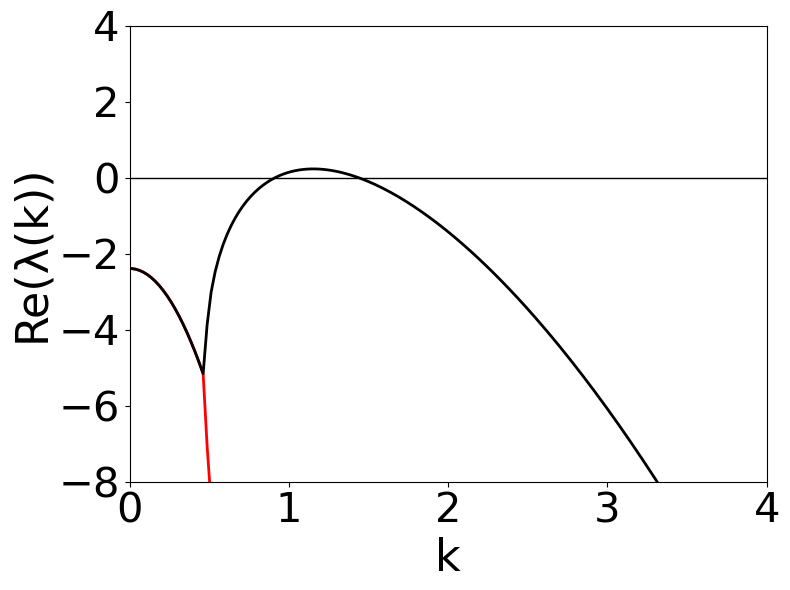

In [34]:
# Dispersion relation plots

for i, ss in enumerate(steady_states):
    # Jacobian at steady state
    J_num = np.array(J.subs({a: ss[0], b: ss[1]}).evalf(), dtype=float)
    eigvals = np.linalg.eigvals(J_num)

    ks = np.linspace(0.01, 5, 200)
    max_eigs = []
    eig1, eig2 = [], []
    ieig1, ieig2 = [], []

    for k in ks:
        M = J_num - np.diag([D_u*k**2, D_v*k**2])
        lam = np.linalg.eigvals(M)
        lam = np.array(sorted(lam, key=lambda x: np.real(x)))
        eig1.append(np.real(lam[0]))
        eig2.append(np.real(lam[1]))
        ieig1.append(np.imag(lam[0]))
        ieig2.append(np.imag(lam[1]))
        max_eigs.append(np.max(np.real(lam)))

    # Plot eigenvalue branches
    plt.figure(figsize=(8,6))
    plt.plot(ks,eig1, '-', label=f"ss{i+1} λ1 (a={ss[0]:.2f}, b={ss[1]:.2f})",linewidth = 2, color = 'red')
    plt.plot(ks,eig2, '-', label=f"ss{i+1} λ1 (a={ss[0]:.2f}, b={ss[1]:.2f})",linewidth = 2, color = 'black')
    # plt.plot(ks,ieig1, '--', label=f"ss{i+1} λ1 (a={ss[0]:.2f}, b={ss[1]:.2f})",linewidth = 2, color = 'red')
    # plt.plot(ks,ieig2, '--', label=f"ss{i+1} λ1 (a={ss[0]:.2f}, b={ss[1]:.2f})",linewidth = 2, color = 'black')
    plt.axhline(0, color='k', linewidth=1)
    plt.xlim(0,4)
    plt.ylim(-8,4)
    plt.yticks(fontsize = 30)
    plt.xticks([0,1,2,3,4],[0,1,2,3,4],fontsize = 30)
    plt.xlabel("k",fontsize = 32)
    plt.ylabel("Re(λ(k))",fontsize = 32)
    #plt.ylabel("eig",fontsize = 32)
    plt.tight_layout()
    #plt.savefig(f"Images_for_paper/supp_fig8c{i}")
    plt.show()
    

# Add reference line

